# Prototyping the 3-Beam Solution

In [1]:
import datetime
import json
import netrc
import requests
import time

import numpy as np
import xarray as xr

from bokeh.models import Range1d, LinearAxis
from bokeh.plotting import figure, show
from bokeh.palettes import Colorblind as palette
from bokeh.io import output_notebook

import warnings
warnings.filterwarnings('ignore')

In [2]:
netrc = netrc.netrc()
auth = netrc.authenticators('ooinet.oceanobservatories.org')

In [3]:
DATA_API_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'
data_request_url = (DATA_API_BASE_URL + 
                    'RS01SLBS/' +                          # Site designator
                    'LJ01A/' +                             # Node designator
                    '10-ADCPTE101/' +                      # Instrument designator
                    'streamed/' +                          # Data delivery method
                    'adcp_velocity_beam' + '?' +           # Data stream name
                    'beginDT=2019-02-26T00:00:00.000Z&' +  # Beginning time range
                    'endDT=2019-03-01T23:59:59.999Z&' +    # Ending time range
                    'format=application/netcdf')           # Specifying we want NetCDF data files

In [4]:
# Put the request in for the data (this will generate an email to the account you used to sign in with).
r = requests.get(data_request_url, auth=(auth[0], auth[2]))
data = r.json()

In [5]:
print(json.dumps(data, indent=2))

{
  "allURLs": [
    "https://opendap.oceanobservatories.org/thredds/catalog/ooi/wruef@uw.edu/20191106T000114789Z-RS01SLBS-LJ01A-10-ADCPTE101-streamed-adcp_velocity_beam/catalog.html", 
    "https://opendap.oceanobservatories.org/async_results/wruef@uw.edu/20191106T000114789Z-RS01SLBS-LJ01A-10-ADCPTE101-streamed-adcp_velocity_beam"
  ], 
  "sizeCalculation": 283415713, 
  "numberOfSubJobs": 4, 
  "timeCalculation": 60, 
  "requestUUID": "a8ea2282-dbc8-42a3-a665-a42d03c39426", 
  "outputURL": "https://opendap.oceanobservatories.org/thredds/catalog/ooi/wruef@uw.edu/20191106T000114789Z-RS01SLBS-LJ01A-10-ADCPTE101-streamed-adcp_velocity_beam/catalog.html"
}


In [6]:
%%time

check_complete = data['allURLs'][1] + '/status.txt'  # When SOA is actually not that efficient...
for i in range(1000): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(.5)

request completed
CPU times: user 4.04 s, sys: 260 ms, total: 4.3 s
Wall time: 3min 1s


In [8]:
# Add some addition modules
from BeautifulSoup import BeautifulSoup
import re

# Function to create a list of the data files of interest
def list_files(url, tag=''):
    page = requests.get(url)
    soup = BeautifulSoup(page.text.encode('utf-8'))
    pattern = re.compile(str(tag))
    return [node.get('href') for node in soup.findAll('a', attrs={'href': pattern})]

# Function to download one of the NetCDF files and convert to a dataset
def process_file(file):
    # download and convert the data
    baseurl = 'https://opendap.oceanobservatories.org/thredds/dodsC/'
    url = re.sub('catalog.html\?dataset=', baseurl, file)
    ds = xr.open_dataset(url).load()  # download the data first, before converting
    ds = ds.swap_dims({'obs': 'time'})
    ds = ds.drop(['obs', 'id', 'driver_timestamp', 'ingestion_timestamp', 'internal_timestamp', 
                  'port_timestamp', 'preferred_timestamp', 'provenance'])
    
    # resample the burst data data into median averaged bursts -- make it a little easier to work with
    ds = ds.reset_coords()
    bursts = ds.resample(time='5Min').median()
    
    # reset the attributes.
    bursts.attrs = ds.attrs
    for v in bursts.variables:
        bursts[v].attrs = ds[v].attrs

    return bursts

In [9]:
# Create a list of the files from June using a simple regex as tag to discriminate the files
files = list_files(data['allURLs'][0], 'deployment.*ADCPT.*\.nc$')

# Process the data files for June and concatenate into a single dataframe
frames = [process_file(f) for f in files]
adcp = xr.concat(frames, 'time')

In [10]:
adcp

<xarray.Dataset>
Dimensions:                         (bin: 50, time: 1152)
Coordinates:
  * time                            (time) datetime64[ns] 2019-02-26 ...
Dimensions without coordinates: bin
Data variables:
    deployment                      (time) float64 4.0 4.0 4.0 4.0 4.0 4.0 ...
    bin_1_distance                  (time) float64 1.236e+03 1.236e+03 ...
    cell_length                     (time) float64 800.0 800.0 800.0 800.0 ...
    correlation_magnitude_beam1     (time, bin) float64 126.5 124.0 127.0 ...
    correlation_magnitude_beam2     (time, bin) float64 119.0 131.0 126.0 ...
    correlation_magnitude_beam3     (time, bin) float64 124.0 130.0 128.0 ...
    correlation_magnitude_beam4     (time, bin) float64 113.0 132.0 129.0 ...
    echo_intensity_beam1            (time, bin) float64 116.0 104.0 98.0 ...
    echo_intensity_beam2            (time, bin) float64 105.0 109.0 98.0 ...
    echo_intensity_beam3            (time, bin) float64 112.5 110.0 104.0 ...
    echo_i

In [11]:
# pull in the needed ion_functions modules
from ion_functions.data.generic_functions import magnetic_declination, replace_fill_with_nan
from ion_functions.data.adcp_functions import ADCP_FILLVALUE, magnetic_correction, adcp_ins2earth

In [12]:
# create an updated beam2ins function that will compute a 3-beam solution.
def adcp_beam_earth(b1, b2, b3, b4, pg1, pg2, pg3, pg4, h, p, r, vf, lat, lon, dt):
    """
    Instead of using the individual wrapper functions outlined in the adcp_functions module
    for the eastward, northward, vertical and error velocities, I've combined them into a
    single function.
    """
    # force shapes of some inputs to arrays of the correct dimensions
    lat = np.atleast_1d(lat)
    lon = np.atleast_1d(lon)
    dt = np.atleast_1d(dt)

    # compute the beam to instrument transform
    x, y, z, e = adcp_beam2ins(b1, b2, b3, b4, pg1, pg2, pg3, pg4)

    # compute the instrument to earth beam transform
    u, v, w = adcp_ins2earth(x, y, z, h, p, r, vf)

    # compute the magnetic variation, and ...
    theta = magnetic_declination(lat, lon, dt)

    # ... correct for it
    u_cor, v_cor = magnetic_correction(theta, u, v)

    # scale velocity from mm/s to m/s
    u_cor = u_cor / 1000.
    v_cor = v_cor / 1000.
    w = w / 1000.
    e = e / 1000.
    
    # return the velocity profiles
    return u_cor, v_cor, w, e

def adcp_beam2ins(b1, b2, b3, b4, pg1, pg2, pg3, pg4):
    """
    Description:
        This function converts the Beam Coordinate transformed velocity
        profiles to the instrument coordinate system. The calculations are
        defined in the Data Product Specification for Velocity Profile and Echo
        Intensity - DCN 1341-00750.
    Implemented by:
        2013-04-10: Christopher Wingard. Initial code.
        2015-06-24: Russell Desiderio. Incorporated int fillvalue -> Nan.
        2019-08-13: Christopher Wingard. Adds functionality to compute a 3-beam solution
                    and cleans up syntax used in the function.
    Usage:
        x, y, z, e = adcp_beam2ins(b1, b2, b3, b4, pg1, pg2, pg3, pg4)
            where
        x = x axis velocity profiles in instrument coordinates [mm s-1]
        y = y axis velocity profiles in instrument coordinates [mm s-1]
        z = z axis velocity profiles in instrument coordinates [mm s-1]
        e = error velocity profiles [mm s-1]
        b1 = beam 1 velocity profiles in beam coordinates [mm s-1]
        b2 = beam 2 velocity profiles in beam coordinates [mm s-1]
        b3 = beam 3 velocity profiles in beam coordinates [mm s-1]
        b4 = beam 4 velocity profiles in beam coordinates [mm s-1]
        pg1 = percent good estimate for beam 1 [percent]
        pg2 = percent good estimate for beam 2 [percent]
        pg3 = percent good estimate for beam 3 [percent]
        pg4 = percent good estimate for beam 4 [percent]
    References:
        OOI (2012). Data Product Specification for Velocity Profile and Echo Intensity. Document Control Number
            1341-00750. https://alfresco.oceanobservatories.org/ (See: Company Home >> OOI >> Cyberinfrastructure >>
            Data Product Specifications >> 1341-00750_Data_Product_SPEC_VELPROF_ECHOINT_OOI.pdf)
        OOI (2013). Data Product Specification for Turbulent Velocity Profile and Echo Intensity. Document Control
            Number 1341-00760. https://alfresco.oceanobservatories.org/ (See: Company Home >> OOI >>
            Cyberinfrastructure >> Data Product Specifications >>  1341-00760_Data_Product_VELTURB_ECHOINT.pdf)
        Teledyne RD Instruments (2008). ADCP Coordinate Transformation, Formulas and Calculations.
    """
    # raw beam velocities, set to correct shape
    b1 = np.atleast_2d(b1)
    b2 = np.atleast_2d(b2)
    b3 = np.atleast_2d(b3)
    b4 = np.atleast_2d(b4)

    # percentage of good pings for each beam per depth cell, set to correct shape
    pg1 = np.atleast_2d(pg1)
    pg2 = np.atleast_2d(pg2)
    pg3 = np.atleast_2d(pg3)
    pg4 = np.atleast_2d(pg4)

    # using the vendor specified percent good floor of 25%, create masked arrays with fill values set to compute
    # a 3-beam solution, if applicable.
    ma1 = np.ma.masked_where(pg1 < 25, b1)
    bm1 = ma1.filled((b2 - b3 - b4) * -1)
    ma2 = np.ma.masked_where(pg2 < 25, b2)
    bm2 = ma2.filled((b1 - b3 - b4) * -1)
    ma3 = np.ma.masked_where(pg3 < 25, b3)
    bm3 = ma3.filled(b1 + b2 - b4)
    ma4 = np.ma.masked_where(pg4 < 25, b4)
    bm4 = ma4.filled(b1 + b2 - b3)

    # sum across the masked arrays to determine if more than 1 beam is bad per depth cell, if so we cannot compute a
    # 3-beam solution and need to set the fill value to a NaN.
    mad = np.ma.dstack((ma1, ma2, ma3, ma4))    # stack the masked arrays in depth
    mas = np.ma.count_masked(mad, axis=2)       # count the number of depth cells masked in the depth stacked array

    # using the above, reset the raw beams. fill with 3-beam if applicable, otherwise use a NaN
    bm1 = np.ma.filled(np.ma.masked_where(mas > 1, bm1), ADCP_FILLVALUE)
    bm2 = np.ma.filled(np.ma.masked_where(mas > 1, bm2), ADCP_FILLVALUE)
    bm3 = np.ma.filled(np.ma.masked_where(mas > 1, bm3), ADCP_FILLVALUE)
    bm4 = np.ma.filled(np.ma.masked_where(mas > 1, bm4), ADCP_FILLVALUE)

    bm1, bm2, bm3, bm4 = replace_fill_with_nan(ADCP_FILLVALUE, bm1, bm2, bm3, bm4)

    theta = 20.0 / 180.0 * np.pi
    a = 1.0 / (2.0 * np.sin(theta))
    b = 1.0 / (4.0 * np.cos(theta))
    c = 1.0   # +1.0 for convex transducer head, -1 for concave
    d = a / np.sqrt(2.0)

    x = c * a * (bm1 - bm2)
    y = c * a * (bm4 - bm3)
    z = b * (bm1 + bm2 + bm3 + bm4)
    e = d * (bm1 + bm2 - bm3 - bm4)

    return x, y, z, e

In [13]:
# setup the inputs
b1 = adcp.velocity_beam1.values  # reported as a float, convert back to integer with proper fill value
b1 = np.ma.filled(np.ma.masked_where(np.isnan(b1), b1), ADCP_FILLVALUE).astype('int')
b2 = adcp.velocity_beam2.values  # reported as a float, convert back to integer with proper fill value
b2 = np.ma.filled(np.ma.masked_where(np.isnan(b2), b2), ADCP_FILLVALUE).astype('int')
b3 = adcp.velocity_beam3.values  # reported as a float, convert back to integer with proper fill value
b3 = np.ma.filled(np.ma.masked_where(np.isnan(b3), b3), ADCP_FILLVALUE).astype('int')
b4 = adcp.velocity_beam4.values  # reported as a float, convert back to integer with proper fill value
b4 = np.ma.filled(np.ma.masked_where(np.isnan(b4), b4), ADCP_FILLVALUE).astype('int')
pg1 = adcp.percent_good_beam1.values
pg2 = adcp.percent_good_beam2.values
pg3 = adcp.percent_good_beam3.values
pg4 = adcp.percent_good_beam4.values
h = adcp.heading.values
p = adcp.pitch.values
r = adcp['roll'].values
vf = adcp.sysconfig_vertical_orientation.values
lat = 44.51519
lon = -125.38987
dt = adcp.time.values.astype(float) / 10.0**9
bin_depth = adcp.bin_depths.values

In [14]:
# calculate the velocity profiles with the newer 3-beam solution algorithm
u_cor, v_cor, w, e = adcp_beam_earth(b1, b2, b3, b4, pg1, pg2, pg3, pg4, h, p, r, vf, lat, lon, dt)

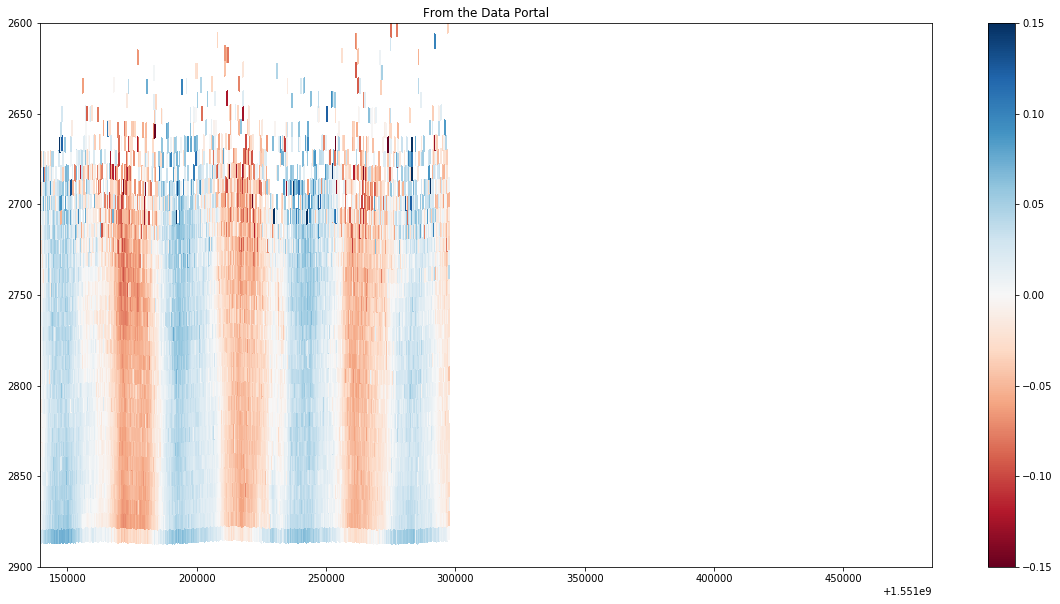

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [20, 10]
plt.pcolor(dt, bin_depth.T, adcp.eastward_seawater_velocity.values.T, cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.title('From the Data Portal')
# set the limits of the plot to the limits of the data
plt.axis([dt.min(), dt.max(), 2600, 2900])
plt.colorbar()
ax = plt.gca()
ax.invert_yaxis()
plt.show()

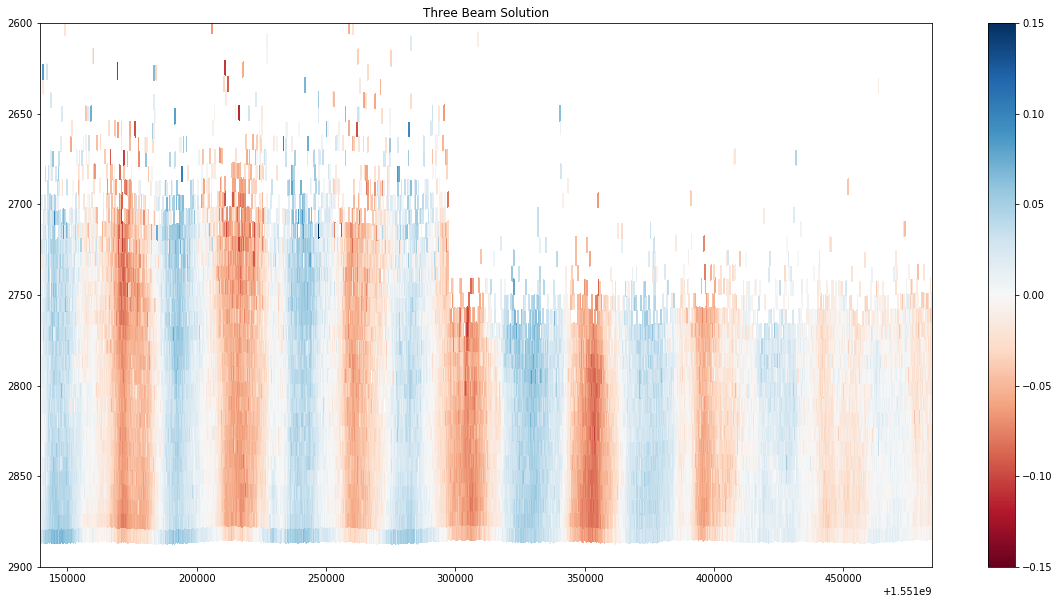

In [16]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.pcolor(dt, bin_depth.T, u_cor.T, cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.title('Three Beam Solution')
# set the limits of the plot to the limits of the data
plt.axis([dt.min(), dt.max(), 2600, 2900])
plt.colorbar()
ax = plt.gca()
ax.invert_yaxis()
plt.show()

In [40]:
# simulate bad beam by filling array with zeroes

b1_bad = np.zeros((len(b1),50), dtype=int)
b2_bad = np.zeros((len(b2),50), dtype=int)
b3_bad = np.zeros((len(b3),50), dtype=int)
b4_bad = np.zeros((len(b4),50), dtype=int)

# set percent good beams to zeroes
pg1_bad = np.zeros((len(pg1),50), dtype=int)
pg2_bad = np.zeros((len(pg2),50), dtype=int)
pg3_bad = np.zeros((len(pg3),50), dtype=int)
pg4_bad = np.zeros((len(pg4),50), dtype=int)


In [41]:
# calculate the velocity profiles with the newer 3-beam solution algorithm using simulated bad data

# beam1 and percent good filled with zeroes:
u_cor_b1_bad, v_cor_b1_bad, w_b1_bad, e_b1_bad = adcp_beam_earth(b1_bad, b2, b3, b4, pg1_bad, pg2, pg3, pg4, h, p, r, vf, lat, lon, dt)

# beam2 and percent good filled with zeroes:
u_cor_b2_bad, v_cor_b2_bad, w_b2_bad, e_b2_bad = adcp_beam_earth(b1, b2_bad, b3, b4, pg1, pg2_bad, pg3, pg4, h, p, r, vf, lat, lon, dt)

# beam3 and percent good filled with zeroes:
u_cor_b3_bad, v_cor_b3_bad, w_b3_bad, e_b3_bad = adcp_beam_earth(b1, b2, b3_bad, b4, pg1, pg2, pg3_bad, pg4, h, p, r, vf, lat, lon, dt)

# beam4 and percent good filled with zeroes:
u_cor_b4_bad, v_cor_b4_bad, w_b4_bad, e_b4_bad = adcp_beam_earth(b1, b2, b3, b4_bad, pg1, pg2, pg3, pg4_bad, h, p, r, vf, lat, lon, dt)



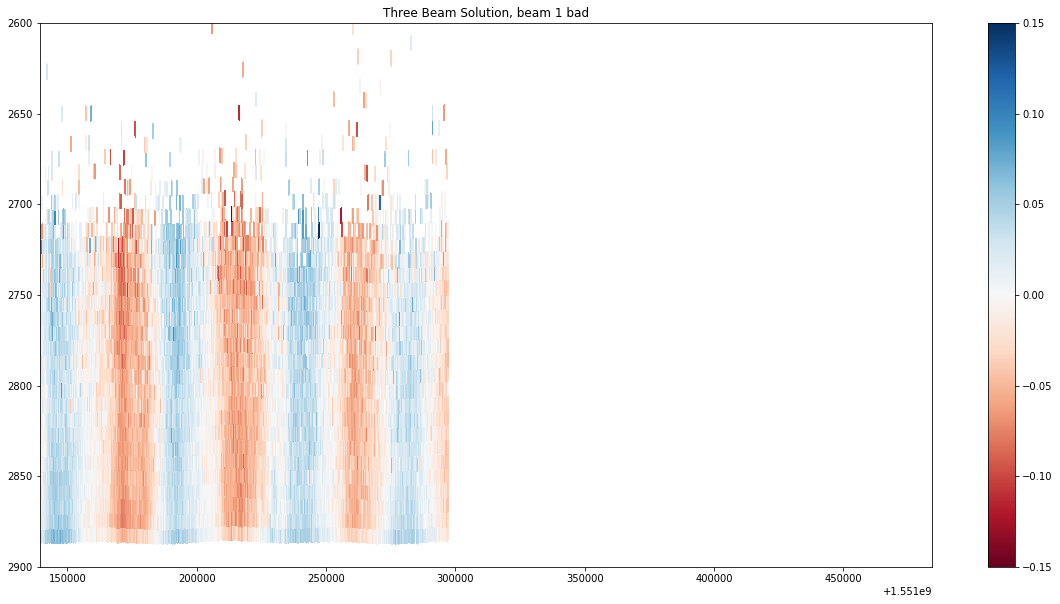

In [42]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.pcolor(dt, bin_depth.T, u_cor_b1_bad.T, cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.title('Three Beam Solution, beam 1 bad')
# set the limits of the plot to the limits of the data
plt.axis([dt.min(), dt.max(), 2600, 2900])
plt.colorbar()
ax = plt.gca()
ax.invert_yaxis()
plt.show()

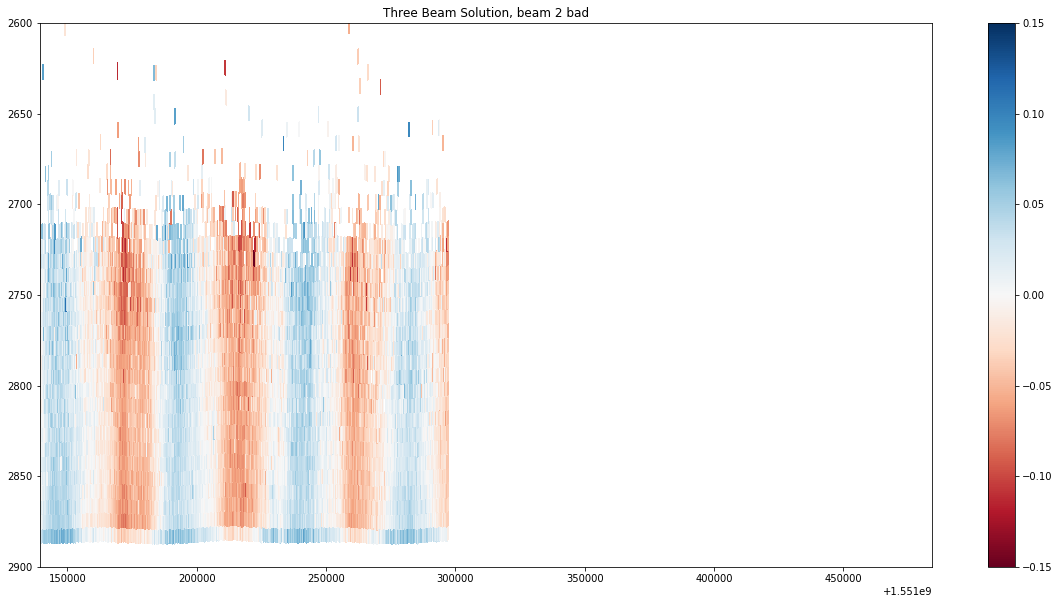

In [43]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.pcolor(dt, bin_depth.T, u_cor_b2_bad.T, cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.title('Three Beam Solution, beam 2 bad')
# set the limits of the plot to the limits of the data
plt.axis([dt.min(), dt.max(), 2600, 2900])
plt.colorbar()
ax = plt.gca()
ax.invert_yaxis()
plt.show()

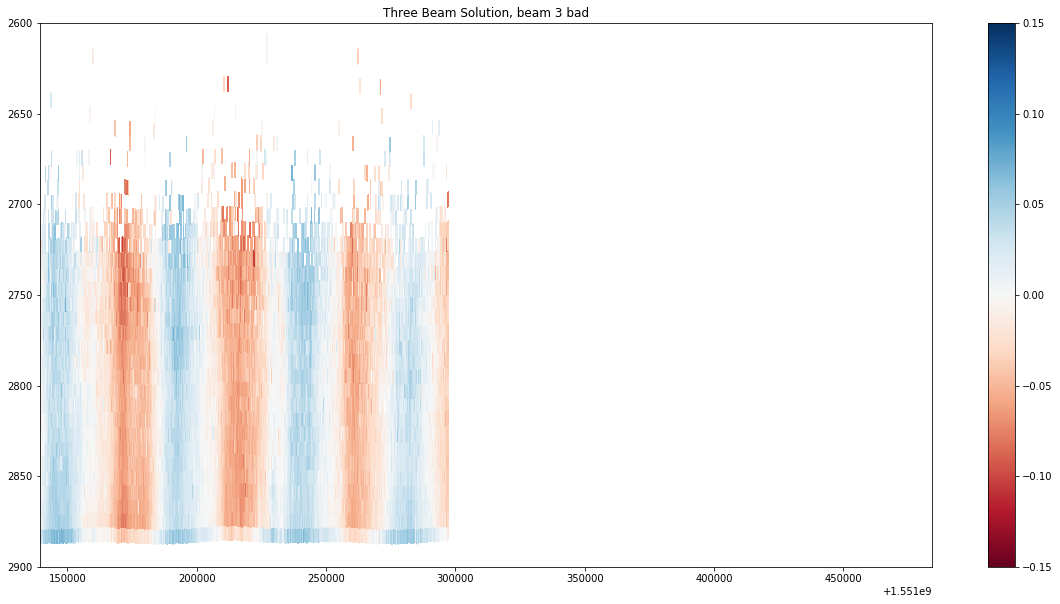

In [44]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.pcolor(dt, bin_depth.T, u_cor_b3_bad.T, cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.title('Three Beam Solution, beam 3 bad')
# set the limits of the plot to the limits of the data
plt.axis([dt.min(), dt.max(), 2600, 2900])
plt.colorbar()
ax = plt.gca()
ax.invert_yaxis()
plt.show()

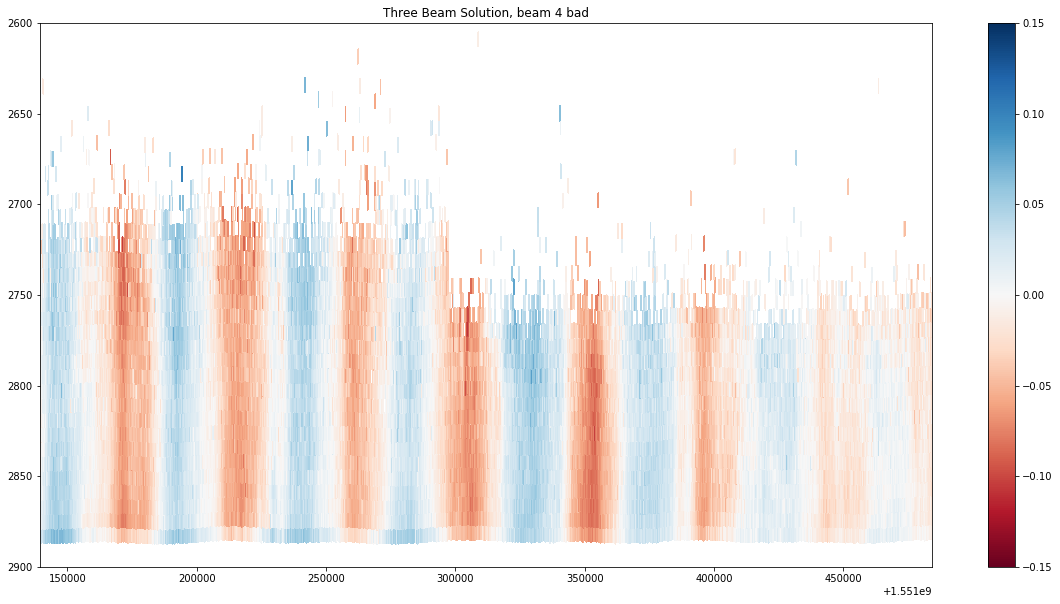

In [45]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.pcolor(dt, bin_depth.T, u_cor_b4_bad.T, cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.title('Three Beam Solution, beam 4 bad')
# set the limits of the plot to the limits of the data
plt.axis([dt.min(), dt.max(), 2600, 2900])
plt.colorbar()
ax = plt.gca()
ax.invert_yaxis()
plt.show()

In [55]:
b1_avg = np.nanmean(u_cor.T - u_cor_b1_bad.T)
b2_avg = np.nanmean(u_cor.T - u_cor_b2_bad.T)
b3_avg = np.nanmean(u_cor.T - u_cor_b3_bad.T)
b4_avg = np.nanmean(u_cor.T - u_cor_b4_bad.T)

print('Beam 1: ' + str(b1_avg) + ' Beam 2: ' + str(b2_avg) + ' Beam 3: ' + str(b3_avg) + ' Beam 4: ' + str(b4_avg) )

Beam 1: 6.757902474080643e-05 Beam 2: -6.83396800352864e-05 Beam 3: -1.1354546346839972e-05 Beam 4: 6.072101263376201e-06


In [56]:
b1_avg = np.nanmean(adcp.eastward_seawater_velocity.values.T - u_cor_b1_bad.T)
b2_avg = np.nanmean(adcp.eastward_seawater_velocity.values.T - u_cor_b2_bad.T)
b3_avg = np.nanmean(adcp.eastward_seawater_velocity.values.T - u_cor_b3_bad.T)
b4_avg = np.nanmean(adcp.eastward_seawater_velocity.values.T - u_cor_b4_bad.T)

print('Beam 1: ' + str(b1_avg) + ' Beam 2: ' + str(b2_avg) + ' Beam 3: ' + str(b3_avg) + ' Beam 4: ' + str(b4_avg) )


Beam 1: 0.004168426231314932 Beam 2: 0.003988994897981884 Beam 3: 0.004026775207899458 Beam 4: 0.004062224377480727


# Verification (loose) against the VEL3d at DP01A

In [16]:
data_request_url = (DATA_API_BASE_URL + 
                    'RS01SLBS/' +                          # Site designator
                    'LJ01A/' +                             # Node designator
                    '10-ADCPTE101/' +                      # Instrument designator
                    'streamed/' +                          # Data delivery method
                    'adcp_velocity_beam' + '?' +           # Data stream name
                    'beginDT=2019-07-02T20:00:00.000Z&' +  # Beginning time range
                    'endDT=2019-07-07T18:00:00.000Z&' +    # Ending time range
                    'format=application/netcdf')           # Specifying we want NetCDF data files

In [17]:
# Put the request in for the data (this will generate an email to the account you used to sign in with).
r = requests.get(data_request_url, auth=(auth[0], auth[2]))
data = r.json()

In [18]:
%%time

check_complete = data['allURLs'][1] + '/status.txt'  # When SOA is actually not that efficient...
for i in range(1000): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(.5)

request completed
CPU times: user 6.25 s, sys: 212 ms, total: 6.46 s
Wall time: 3min


In [19]:
# Create a list of the files from June using a simple regex as tag to discriminate the files
files = list_files(data['allURLs'][0], 'deployment.*ADCPT.*\.nc$')

# Process the data files for June and concatenate into a single dataframe
frames = [process_file(f) for f in files]
adcp = xr.concat(frames, 'time')

In [20]:
# setup the inputs
b1 = adcp.velocity_beam1.values  # reported as a float, convert back to integer with proper fill value
b1 = np.ma.filled(np.ma.masked_where(np.isnan(b1), b1), ADCP_FILLVALUE).astype('int')
b2 = adcp.velocity_beam2.values  # reported as a float, convert back to integer with proper fill value
b2 = np.ma.filled(np.ma.masked_where(np.isnan(b2), b2), ADCP_FILLVALUE).astype('int')
b3 = adcp.velocity_beam3.values  # reported as a float, convert back to integer with proper fill value
b3 = np.ma.filled(np.ma.masked_where(np.isnan(b3), b3), ADCP_FILLVALUE).astype('int')
b4 = adcp.velocity_beam4.values  # reported as a float, convert back to integer with proper fill value
b4 = np.ma.filled(np.ma.masked_where(np.isnan(b4), b4), ADCP_FILLVALUE).astype('int')
pg1 = adcp.percent_good_beam1.values
pg2 = adcp.percent_good_beam2.values
pg3 = adcp.percent_good_beam3.values
pg4 = adcp.percent_good_beam4.values
h = adcp.heading.values
p = adcp.pitch.values
r = adcp['roll'].values
vf = adcp.sysconfig_vertical_orientation.values
lat = 44.51519
lon = -125.38987
dt = adcp.time.values.astype(float) / 10.0**9
bin_depth = adcp.bin_depths.values

In [21]:
# calculate the velocity profiles with the newer 3-beam solution algorithm
u_cor, v_cor, w, e = adcp_beam_earth(b1, b2, b3, b4, pg1, pg2, pg3, pg4, h, p, r, vf, lat, lon, dt)

In [22]:
# Pull data from NC Files
ctdpf = xr.open_dataset('./DP01A-CTDPFL104.nc').load()
ctdpf = ctdpf.swap_dims({'obs': 'time'})
ctdpf = ctdpf.drop(['obs', 'id'])
vel3d = xr.open_dataset('./DP01A-VEL3DA103.nc').load()
vel3d = vel3d.swap_dims({'obs': 'time'})
vel3d = vel3d.drop(['obs', 'id', 'driver_timestamp', 'ingestion_timestamp', 'internal_timestamp', 
                  'port_timestamp', 'preferred_timestamp'])


In [23]:
# merge the ctd data into the vel3d
vel3d = xr.merge([vel3d, ctdpf])

# resample the data into median averaged records -- make it a little easier to work with
vel3d = vel3d.reset_coords()
bursts = vel3d.resample(time='5Min').median()

# reset the attributes.
bursts.attrs = vel3d.attrs
for v in bursts.variables:
    bursts[v].attrs = vel3d[v].attrs

vt = bursts.time.values.astype(float) / 10.0**9
vp = bursts.pressure.values
ve = bursts.vel3d_a_eastward_velocity.values

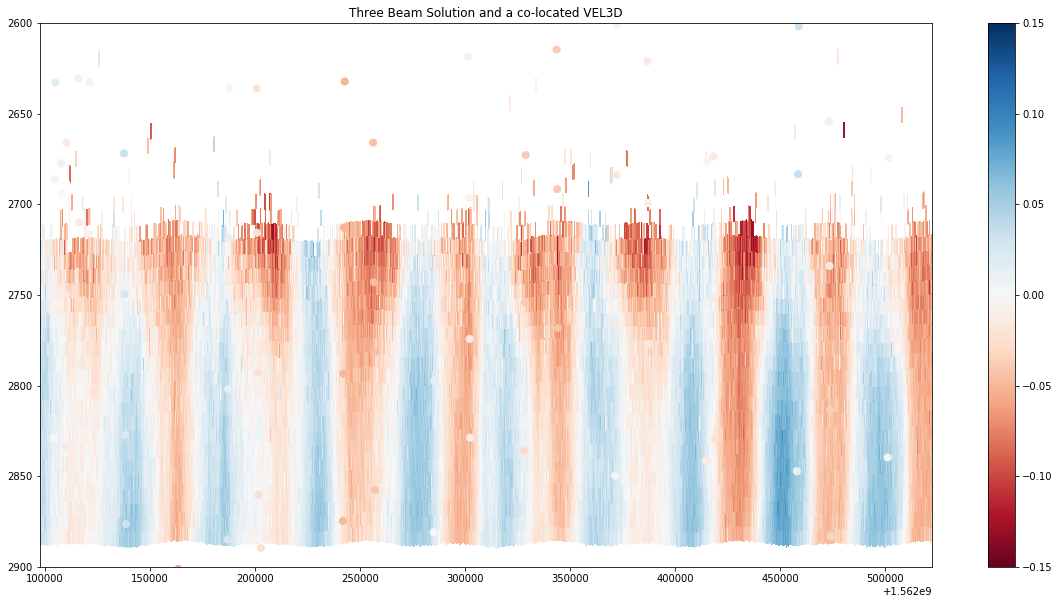

In [24]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.title('Three Beam Solution and a co-located VEL3D')
plt.pcolor(dt, bin_depth.T, u_cor.T, cmap='RdBu', vmin=-0.15, vmax=0.15, alpha=1)
plt.scatter(vt, vp, s=50, c=ve, cmap='RdBu', vmin=-0.15, vmax=0.15)
# set the limits of the plot to the limits of the data
plt.axis([dt.min(), dt.max(), 2600, 2900])
plt.colorbar()
ax = plt.gca()
ax.invert_yaxis()
plt.show()